## Importing Dependencies - Run twice in case of deprecation error

In [5]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np
import random
from scipy import stats
import pandas as pd
import os
import matplotlib.pyplot as plt

from SmartHomeGymEnv_v2_deployment import SmartHomeGymEnv as deployment_env

import ray
from ray.rllib.algorithms.a2c import A2CConfig
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.marwil import  MARWILConfig
from ray.rllib.algorithms.bandit import BanditLinUCBConfig
from ray.tune.registry import register_env
from ray.rllib.examples.models.rnn_model import RNNModel, TorchRNNModel

from ray import tune

from ray.rllib.agents.a3c.a2c import A2CTrainer

from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks,DefaultCallbacks
from ray.air import RunConfig,CheckpointConfig
from ray.tune import TuneConfig

from ray.tune import Callback
from ray.air import session

from typing import TYPE_CHECKING, Dict, List, Optional, Tuple, Type, Union

from ray.rllib.env.base_env import BaseEnv
from ray.rllib.env.env_context import EnvContext
from ray.rllib.evaluation.episode import Episode
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.policy import Policy
from ray.rllib.utils.typing import AgentID, EnvType, PolicyID
from ray.rllib.evaluation import RolloutWorker
from ray.rllib.utils.deprecation import Deprecated, deprecation_warning
from ray.rllib.policy.sample_batch import SampleBatch

from ray.tune.search.optuna import OptunaSearch

import wandb

import random

## Setting up Custom Environment based on information found at : https://www.daftlogic.com/information-appliance-power-consumption.htm

In [6]:
# 1 priority device envs 

priority_user_prob = np.array([
        np.array([0.99, 0.11, 0.99, 0.11]),     
    ])

# 100W light bulb (Incandescent) - 1 day - 0.5 time_step

env_1_pr_device_1d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) - 7 days - 0.5 time_step

env_1_pr_device_7d_05_time_step= deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) - 30 days - 0.5 time_step

env_1_pr_device_30d_05_time_step= deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) - 1 day - 1 time_step

env_1_pr_device_1d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent) - 7 days - 1 time_step

env_1_pr_device_7d_1_time_step= deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent) - 30 days - 1 time_step

env_1_pr_device_30d_1_time_step= deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                            deferrable_n_devices=0,
                            episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 5 priority devices env

priority_user_prob = np.array([
            np.array([0.99, 0.11, 0.99, 0.11]),        
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11])
        ])

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 1 day - 0.5 time_step

env_5_pr_device_1d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 7 days - 0.5 time_step

env_5_pr_device_7d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=7,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 30 days - 0.5 time_step

env_5_pr_device_30d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=30,priority_user_probabilities=priority_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 1 day - 0.5 time_step

env_5_pr_device_1d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=1,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 7 days - 0.5 time_step

env_5_pr_device_7d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=7,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W - 30 days - 0.5 time_step

env_5_pr_device_30d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=0,
                                episode_horizon=30,priority_user_probabilities=priority_user_prob,time_step_duration=1)

# 1 priority device and 1 deferrable device

priority_user_prob = np.array([
        np.array([0.99, 0.11, 0.99, 0.11]), 
    ])

deferrable_user_prob = np.array([
            np.array([0.9, 0.4, 0.8, 0.3]),    
        ])

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 1 day - 0.5 time_step

env_1_pr_1_df_device_1d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=1,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 7 days - 0.5 time_step

env_1_pr_1_df_device_7d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=7,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 30 days - 0.5 time_step

env_1_pr_1_df_device_30d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=30,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 1 day - 0.5 time_step

env_1_pr_1_df_device_1d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=1,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 7 days - 0.5 time_step

env_1_pr_1_df_device_7d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=7,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 30 days - 0.5 time_step

env_1_pr_1_df_device_30d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=1,priority_device_power_consumption=np.array([0.1]),
                                deferrable_n_devices=1,deferrable_device_power_consumption=np.array([1.3]),
                                deferrable_device_on_duration=np.array([2.5]),
                                episode_horizon=30,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

# 5 priority device and 5 deferrable device

priority_user_prob = np.array([
            np.array([0.99, 0.11, 0.99, 0.11]),        
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11]), 
            np.array([0.99, 0.11, 0.99, 0.11])
        ])

deferrable_user_prob = np.array([
            np.array([0.9, 0.4, 0.8, 0.3]),  
            np.array([0.9, 0.4, 0.8, 0.3]),    
            np.array([0.9, 0.4, 0.8, 0.3]),    
            np.array([0.9, 0.4, 0.8, 0.3]),    
            np.array([0.9, 0.4, 0.8, 0.3]),    
        ])

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W and 
# 1300 dishwasher (2.5 hours function) / 1000 dishwasher (1 hour function) / 2400 Clothes Dryer (0.5 hour function) / 800 Food Dehydrator (4 hour function) / 2150 Oven (2 hour function) 
# - 1 day - 0.5 time_step

env_5_pr_5_df_device_1d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=1,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 7 days - 0.5 time_step

env_5_pr_5_df_device_7d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=7,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent) and 1300 dishwasher (2.5 hours function) - 30 days - 0.5 time_step

env_5_pr_5_df_device_30d_05_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=30,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=0.5)

# 100W light bulb (Incandescent)/ 2500W AC /  60W light bulb (Incandescent) / Ceiling Fan 70W /  Hot Water Dispenser 1300 W and 
# 1300 dishwasher (2.5 hours function) / 1000 dishwasher (1 hour function) / 2400 Clothes Dryer (0.5 hour function) / 800 Food Dehydrator (4 hour function) / 2150 Oven (2 hour function) 
# - 1 day - 1 time_step

env_5_pr_5_df_device_1d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=1,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

# 7 days - 1 time_step

env_5_pr_5_df_device_7d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=7,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

# 30 days - 1 time_step

env_5_pr_5_df_device_30d_1_time_step = deployment_env(data_file='nyiso_hourly_prices.csv',priority_n_devices=5,priority_device_power_consumption=np.array([0.1,2.5,0.06,0.07,1.3]),
                                deferrable_n_devices=5,deferrable_device_power_consumption=np.array([1.3,1,2.4,0.8,2.15]),
                                deferrable_device_on_duration=np.array([2.5,1,0.5,4,2]),
                                episode_horizon=30,priority_user_probabilities=priority_user_prob, deferrable_user_probabilities=deferrable_user_prob,time_step_duration=1)

Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized
Environment successfully initialized


## Loading MARWIL Algorithm Checkpoint and Running it on a Random Day

2023-10-24 15:49:54,789	WARNING deprecation.py:50 -- DeprecationWarning: `MARWIL used to have off_policy_estimation_methods is and wis by default. This haschanged to off_policy_estimation_methods: \{\}.If you want to use an off-policy estimator, specify it in.evaluation(off_policy_estimation_methods=...)` has been deprecated. This will raise an error in the future!


2023-10-24 15:49:54,875	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-10-24 15:49:54,911	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: env_5_pr_5_df_experiments_marwil\timestep_05\training_1d\MARWIL_SmartHomeGymEnv_89533_00000_0_2023-10-20_10-07-54\checkpoint_000022
2023-10-24 15:49:54,911	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 22, '_timesteps_total': None, '_time_total': 30.95060968399048, '_episodes_total': 154}


The mean reward for this episode was: -181.3939091249549


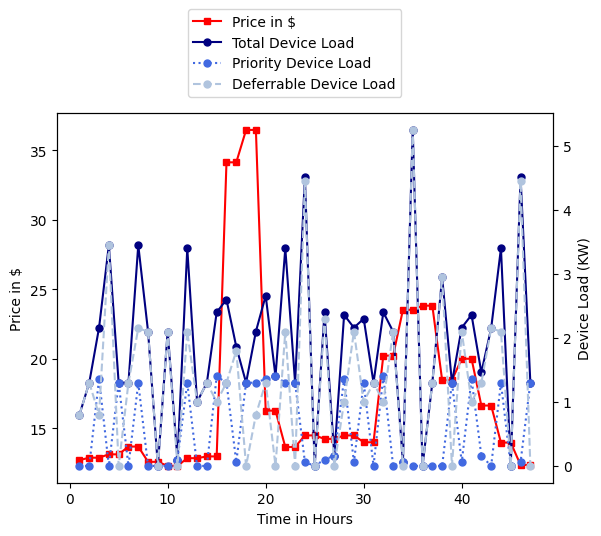

In [10]:
path = "env_5_pr_5_df_experiments_marwil/timestep_05/training_1d/MARWIL_SmartHomeGymEnv_89533_00000_0_2023-10-20_10-07-54/checkpoint_000022"

config = MARWILConfig()
config = config.training(lr=0.001,train_batch_size=300)
config = config.environment(env="SmartHomeGymEnv")
config = config.rollouts(num_rollout_workers=0,batch_mode="complete_episodes",rollout_fragment_length=300,num_envs_per_worker = 1,)
config = config.framework(framework="tf2")#,eager_tracing=True)
config = config.resources(num_gpus=0, num_trainer_workers=1)
config.offline_data(postprocess_inputs=True)
env = env_5_pr_5_df_device_1d_05_time_step
register_env("SmartHomeGymEnv", lambda config: env)  
config = config.environment(env="SmartHomeGymEnv")
algorithm = config.build(env="SmartHomeGymEnv")
# Restore the algo's state from the checkpoint.
algorithm.restore(path)

env.reset()

# Setting json input with which the environment starts
obs = {'priority_devices' : [0,0,0,0,0], 'deferrable_devices' : [0,0,0,0,0], 'deferrable_devices_duration_countdown' : [0,0,0,0,0],
    'energy_price' : [2.0] , 'time' : [0]}

done = False
episode_reward = 0
counter = 0

# Calculate one episode
while not done:
    # Get action based on agent 
    action = algorithm.compute_single_action(obs)
    # Calculate next step
    obs, reward, done, truncated, info = env.step(action)

    episode_reward += reward
    counter +=1

print("The mean reward for this episode was: " + str(episode_reward/counter))

plot_time = info["time"]
plot_price = info["price_history"]
plot_kwh = info["kwh_device_history"]
plot_priority_kwh = info["kwh_priority_device_history"]
plot_deferrable_kwh = info["kwh_deferrable_device_history"]

window_size = 1
moving_average_plot_price = np.convolve(plot_price, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_kwh = np.convolve(plot_kwh, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_priority_kwh = np.convolve(plot_priority_kwh, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_deferrable_kwh = np.convolve(plot_deferrable_kwh, np.ones(window_size)/window_size, mode='valid')

fig,ax1 = plt.subplots()

ax1.set_xlabel('Time in Hours')
ax1.set_ylabel('Price in $')
plot_1 = ax1.plot(plot_time[:47],moving_average_plot_price[:47],color='red', marker = 's', ms = 5)

ax2 = ax1.twinx()
ax2.set_ylabel('Device Load (KW)')
plot_2 = ax2.plot(plot_time[:47],moving_average_plot_kwh[:47],color='navy', marker = 'o', ms = 5)
plot_3 = ax2.plot(plot_time[:47],moving_average_plot_priority_kwh[:47],color='royalblue', marker = 'o', ms = 5,ls=':')
plot_4 = ax2.plot(plot_time[:47],moving_average_plot_deferrable_kwh[:47],color='lightsteelblue', marker = 'o', ms = 5,ls='--')

plt.legend(handles=[plot_1[0], plot_2[0], plot_3[0], plot_4[0]], labels=['Price in $', 'Total Device Load', 'Priority Device Load' , 'Deferrable Device Load'], loc='upper left',bbox_to_anchor=(0.25, 1.3))

plt.show()